In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import imblearn #pip install imblearn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

In [3]:
pd.set_option('display.max_columns', None) #显示所有列
#pd.set_option('display.max_rows', None) #显示所有行
pd.set_option('max_colwidth', 200)

In [4]:
#择列打印
#df_plot = df[['monthly_fee', 'paid_call_duration', 'churn_state_at_the_end_of_month']]
#print(df_plot.iloc[:,0:3])

#择列 并筛选标签为 1 的行 转为 Numpy array --- df_plot.as_matrix(), np.array(df_plot)有同样效果
#print(df_plot.iloc[:,0].loc[df_plot['churn_state_at_the_end_of_month'] == 1].values)

def plot_data(df_plot):
    #matplotlib画图中中文显示会有问题，需要这两行设置默认字体
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    #画两条（0-9）的坐标轴并设置轴标签x，y
    plt.xlabel('X')
    plt.ylabel('Y')
 
    x1 = df_plot.iloc[:,0].loc[df_plot['churn_state_at_the_end_of_month'] == 1].values+300 #加300使两类样本分开些
    y1 = df_plot.iloc[:,1].loc[df_plot['churn_state_at_the_end_of_month'] == 1].values+300
    
    
    x2 = df_plot.iloc[:,0].loc[df_plot['churn_state_at_the_end_of_month'] == 0].values
    y2 = df_plot.iloc[:,1].loc[df_plot['churn_state_at_the_end_of_month'] == 0].values
    
    colors1 = '#DC143C' #点的颜色
    colors2 = '#00CED1'
    area = np.pi *5**2  # 点面积
    
    # 画散点图
    plt.scatter(x1, y1, s=area, c=colors1, alpha=0.4, label='流失1')
    plt.scatter(x2, y2, s=area, c=colors2, alpha=0.4, label='未流失0')
    plt.legend()
    #plt.savefig(r'C:\Users\Zhiyang\Desktop\customer_churn\plotfig, dpi=300)
    #plt.show()


In [5]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False


#字符串前添加r以对抗 UNICODE ERROR
df = pd.read_csv(r'C:\Users\Zhiyang\Desktop\customer_churn\100_data.csv')
#删除索引列
df = df.drop(df.columns[[0]], axis = 1)
#打印
display(df.head(5))

,city_type,credit,join_month,gat_roaming_tag,provincial_roaming_tag,two_low_user_tag,three_low_user_tag,mobile_type,TDLTE_tag,FDLTE_tag,recharge_amount,monthly_fee,grant_amount,arrears_amount,over_product_voice_tag,over_product_stream_income,roaming_call_duration,paid_call_duration,domestic_Long_Distance_Call_Duration,gat_International_Long_Distance_Call_Duration,numbering_of_outgoing_calls,numbering_of_incoming_calls,paid_Data_Traffic,free_Data_Traffic,provincial_Data_Traffic,domestic_Data_Traffic,international_Data_Traffic,data_Traffic_Used_Days,shutdown_Days,sms_numbers,promotion_Tag,churn_state_at_the_start_of_month,churn_state_at_the_end_of_month
0,一线城市,良好,10,0,1,1,0,安卓手机,0,0,100,343,35,14,1,45,62,275,138,70,76,24,63,94,85,1425,1828,27,1,394,1,0,0
1,二线城市,良好,10,1,0,0,0,安卓手机,1,0,150,946,34,33,1,20,351,131,225,275,58,187,87,34,159,3426,1476,49,0,653,0,0,0
2,二线城市,良好,9,0,1,1,0,安卓手机,1,0,50,188,1,17,1,6,1391,221,129,207,147,153,31,104,228,9516,251,29,6,648,1,0,0
3,一线城市,较差,2,1,1,0,0,苹果手机,1,1,50,392,3,32,1,12,2830,261,180,13,131,88,81,92,352,7280,959,21,9,396,1,0,0
4,其他城市,良好,11,1,1,1,0,安卓手机,0,0,150,990,7,27,0,43,999,258,166,301,180,286,90,123,406,7772,2639,37,15,739,0,0,0


In [6]:
df.groupby('churn_state_at_the_end_of_month').churn_state_at_the_end_of_month.count()

churn_state_at_the_end_of_month
0    93
1     7
Name: churn_state_at_the_end_of_month, dtype: int64

In [7]:
'''
测试 SMOTE-oversampling
'''
df_smote = df

#字符串转为数值: df.loc[ df['检索列名']=='被替换值',  '替换列名']  =   替换值

df_smote.loc[df['city_type'] == '其他城市', 'city_type'] = 0
df_smote.loc[df['city_type'] == '一线城市', 'city_type'] = 1
df_smote.loc[df['city_type'] == '二线城市', 'city_type'] = 2

df_smote.loc[df['credit'] == '良好', 'credit'] = 0
df_smote.loc[df['credit'] == '较差', 'credit'] = 1

df_smote.loc[df['mobile_type'] == '安卓手机', 'mobile_type'] = 0
df_smote.loc[df['mobile_type'] == '苹果手机', 'mobile_type'] = 1
display(df_smote.head(5))

,city_type,credit,join_month,gat_roaming_tag,provincial_roaming_tag,two_low_user_tag,three_low_user_tag,mobile_type,TDLTE_tag,FDLTE_tag,recharge_amount,monthly_fee,grant_amount,arrears_amount,over_product_voice_tag,over_product_stream_income,roaming_call_duration,paid_call_duration,domestic_Long_Distance_Call_Duration,gat_International_Long_Distance_Call_Duration,numbering_of_outgoing_calls,numbering_of_incoming_calls,paid_Data_Traffic,free_Data_Traffic,provincial_Data_Traffic,domestic_Data_Traffic,international_Data_Traffic,data_Traffic_Used_Days,shutdown_Days,sms_numbers,promotion_Tag,churn_state_at_the_start_of_month,churn_state_at_the_end_of_month
0,1,0,10,0,1,1,0,0,0,0,100,343,35,14,1,45,62,275,138,70,76,24,63,94,85,1425,1828,27,1,394,1,0,0
1,2,0,10,1,0,0,0,0,1,0,150,946,34,33,1,20,351,131,225,275,58,187,87,34,159,3426,1476,49,0,653,0,0,0
2,2,0,9,0,1,1,0,0,1,0,50,188,1,17,1,6,1391,221,129,207,147,153,31,104,228,9516,251,29,6,648,1,0,0
3,1,1,2,1,1,0,0,1,1,1,50,392,3,32,1,12,2830,261,180,13,131,88,81,92,352,7280,959,21,9,396,1,0,0
4,0,0,11,1,1,1,0,0,0,0,150,990,7,27,0,43,999,258,166,301,180,286,90,123,406,7772,2639,37,15,739,0,0,0


In [8]:
x, y = df_smote.iloc[:,:-1], df_smote.iloc[:,-1]  #分开特征x与标签y, iloc[行，列]

smote_model = SMOTE()
x_smote, y_smote = smote_model.fit_sample(x, y) #SMOTE over-sampling
smote_df = pd.concat([x_smote,y_smote], axis=1)  #contract over-sampled data

smote_df.groupby('churn_state_at_the_end_of_month').churn_state_at_the_end_of_month.count()

churn_state_at_the_end_of_month
0    93
1    93
Name: churn_state_at_the_end_of_month, dtype: int64

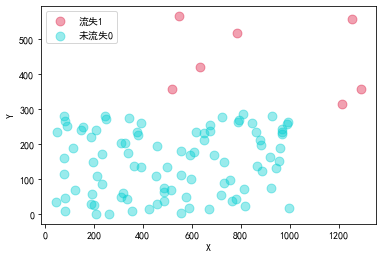

In [9]:
#display(smote_df.churn_state_at_the_end_of_month)
'''
plot df and smote_df
'''
df4plot = df[['monthly_fee', 'paid_call_duration', 'churn_state_at_the_end_of_month']]
plot_data(df4plot)


' SMOTE-oversampling 成功 '

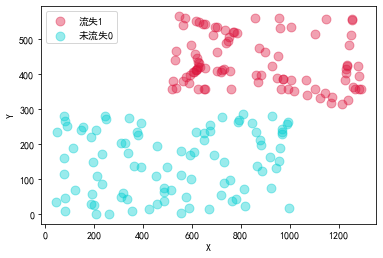

In [10]:
smote_df4plot = smote_df[['monthly_fee', 'paid_call_duration', 'churn_state_at_the_end_of_month']]
plot_data(smote_df4plot)

''' SMOTE-oversampling 成功 '''

In [11]:
'''
测试 Borderline_SMOTE-oversampling

kind = 'regular', 最原始-对少数样本进行随机的过采样
kind = 'borderline1', 仅针对危险样本(即交界样本)进行随机的过采样，生成样本点时必须在和同类(即少数类)的连线上取点
kind = 'borderline2', 仅针对危险样本(即交界样本)进行随机的过采样，生成样本点时可以在和任何类(即少数或多数类)的连线上取点
random_state 0/42 不清楚

'''


df_smote_border = df_smote

xb, yb = df_smote_border.iloc[:,:-1], df_smote_border.iloc[:,-1]

border_smote_model = BorderlineSMOTE()
x_border_smote, y_border_smote = border_smote_model.fit_sample(xb, yb) #Borderline SMOTE over-sampling
border_smote_df = pd.concat([x_border_smote,y_border_smote], axis=1)  #contract over-sampled data
border_smote_df.groupby('churn_state_at_the_end_of_month').churn_state_at_the_end_of_month.count()

churn_state_at_the_end_of_month
0    93
1    93
Name: churn_state_at_the_end_of_month, dtype: int64

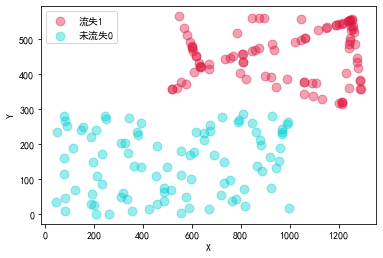

In [12]:
border_smote_df4plot = border_smote_df[['monthly_fee', 'paid_call_duration', 'churn_state_at_the_end_of_month']]
plot_data(border_smote_df4plot)

In [16]:
'''
测试 +Tomeklinks
若a_major与b_minor两点间的距离不是最短的(即还存在任意点C使得distance(a,c)<distance(a,b) 或distance(b,c)<distance(a,b))
则a,b两点全部删掉，是种undersampling欠采样
'''
# https://blog.csdn.net/qq_24591139/article/details/100518532
smote_tomek = SMOTETomek(random_state=0)
X_tom, y_tom = smote_tomek.fit_sample(x, y)
tom_df = pd.concat([X_tom, y_tom], axis=1)  #contract over-sampled data

tom_df.groupby('churn_state_at_the_end_of_month').churn_state_at_the_end_of_month.count()

churn_state_at_the_end_of_month
0    89
1    89
Name: churn_state_at_the_end_of_month, dtype: int64

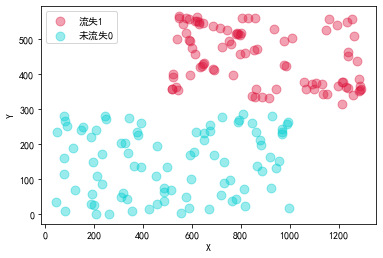

In [19]:
tomek_df4plot = tom_df[['monthly_fee', 'paid_call_duration', 'churn_state_at_the_end_of_month']]
plot_data(tomek_df4plot)